O3 농도 예측 모델의 학습 및 모델 예측 테스트 코드

VER: 
    
    v1.2

SETUP:

    In[NOx, VOC, NH3]
    Out[pred. O3]

STRUCTURE:

    Conditional U-Net
    (Boundary Condition BC=1)

    model = build_model(
        ..., 
        emb_dims=[64],
        ...,
        hidden_size=[64, 96],
        ...,
        in_filters=10,
        ...
    )

PARAMETER:

    EPOCH = 500
    test_split = 0.5

In [ ]:
# Import
import os
import sys
sys.path.append('/home/user/workdir/CMAQ_Emulator/main')

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf

from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

# Training

In [ ]:
dataset_2013 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_matrix_2013_for_o3.csv')
dataset_2013['Boundary'] = 1.0

ctrl_data = pd.concat([dataset_2013], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :17*3], ctrl_data[:, 17*3]
# -------------
label_path_2013 = '/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013'

label_path = []
for i in range(1, 120): 
    label_path.append(os.path.join(label_path_2013, '1.00', f'ACONC.{i}'))

label_data = []
for path in label_path:
    with nc.Dataset(path) as f:
        label_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
label_data = np.array(label_data).reshape(len(label_data), 82, 67, 1)

In [ ]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/final_model'  # 모델 저장 경로

epochs = 500  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.5  # 테스트 데이터 비율 (50%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, label_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*3,
        cond_dim=[1],
        emb_dims=[64],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[64, 96],
        hidden_depth=4,
        in_filters=10,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )
    
# define callback
def scheduler(epoch, lr):
    if epoch <= 1000: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

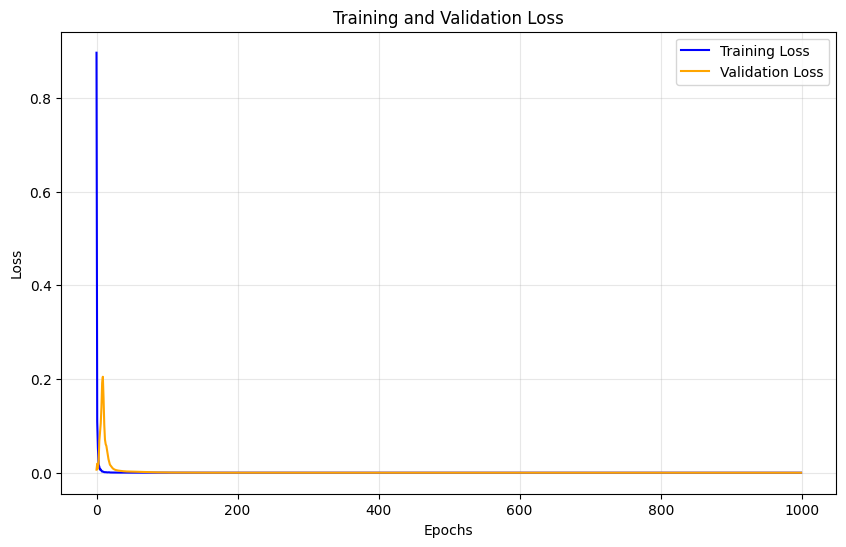

In [ ]:
plot_loss(history)

# Prediction & Performance

In [ ]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/CMAQ_Emulator/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [ ]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/CMAQ_Emulator/main/src/model/o3_prediction/v1/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/CMAQ_Emulator/main/resources/ctrl/precursor_control_matrix_2013_for_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2013 = "/home/user/workdir/CMAQ_Emulator/main/datasets/concentration/2013"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2013, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['O3'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :17*3], ctrl_data[:, 17*3]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 Nitrate
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 1s 22ms/step


In [ ]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [ ]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

In [ ]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


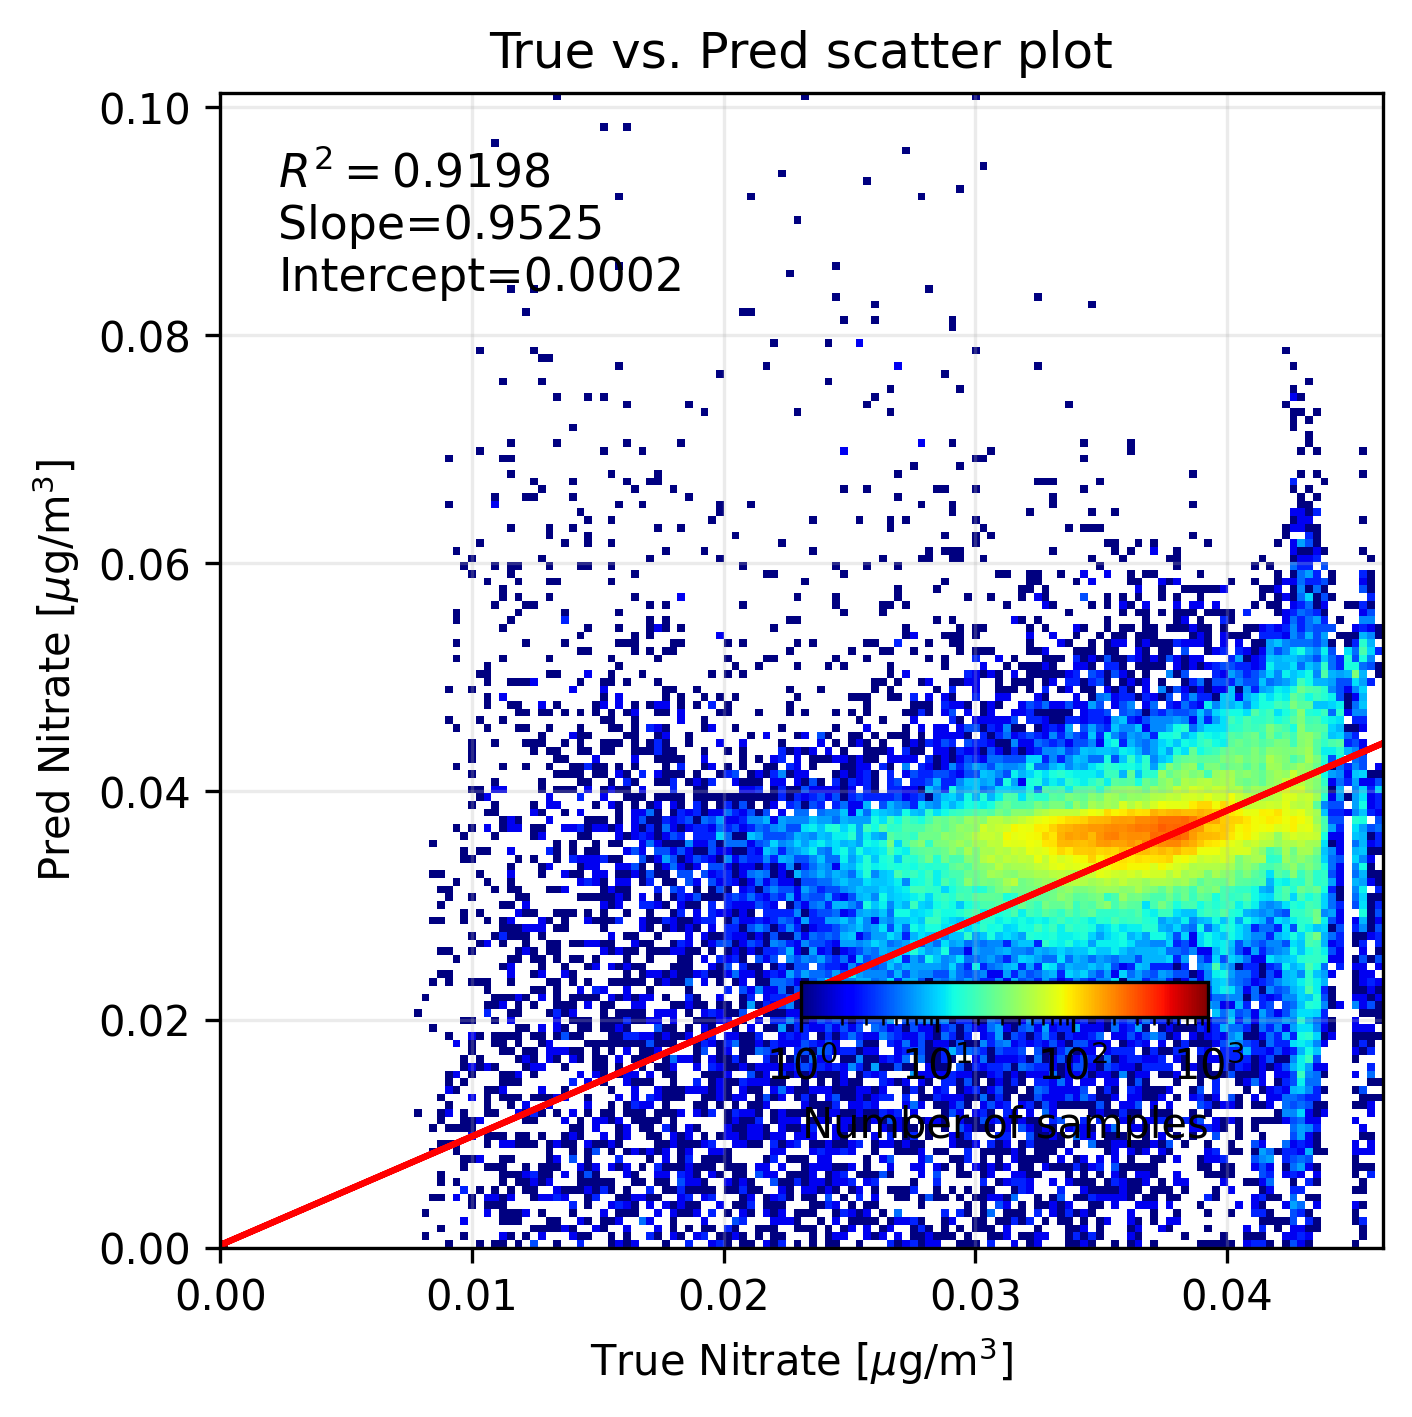

In [ ]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

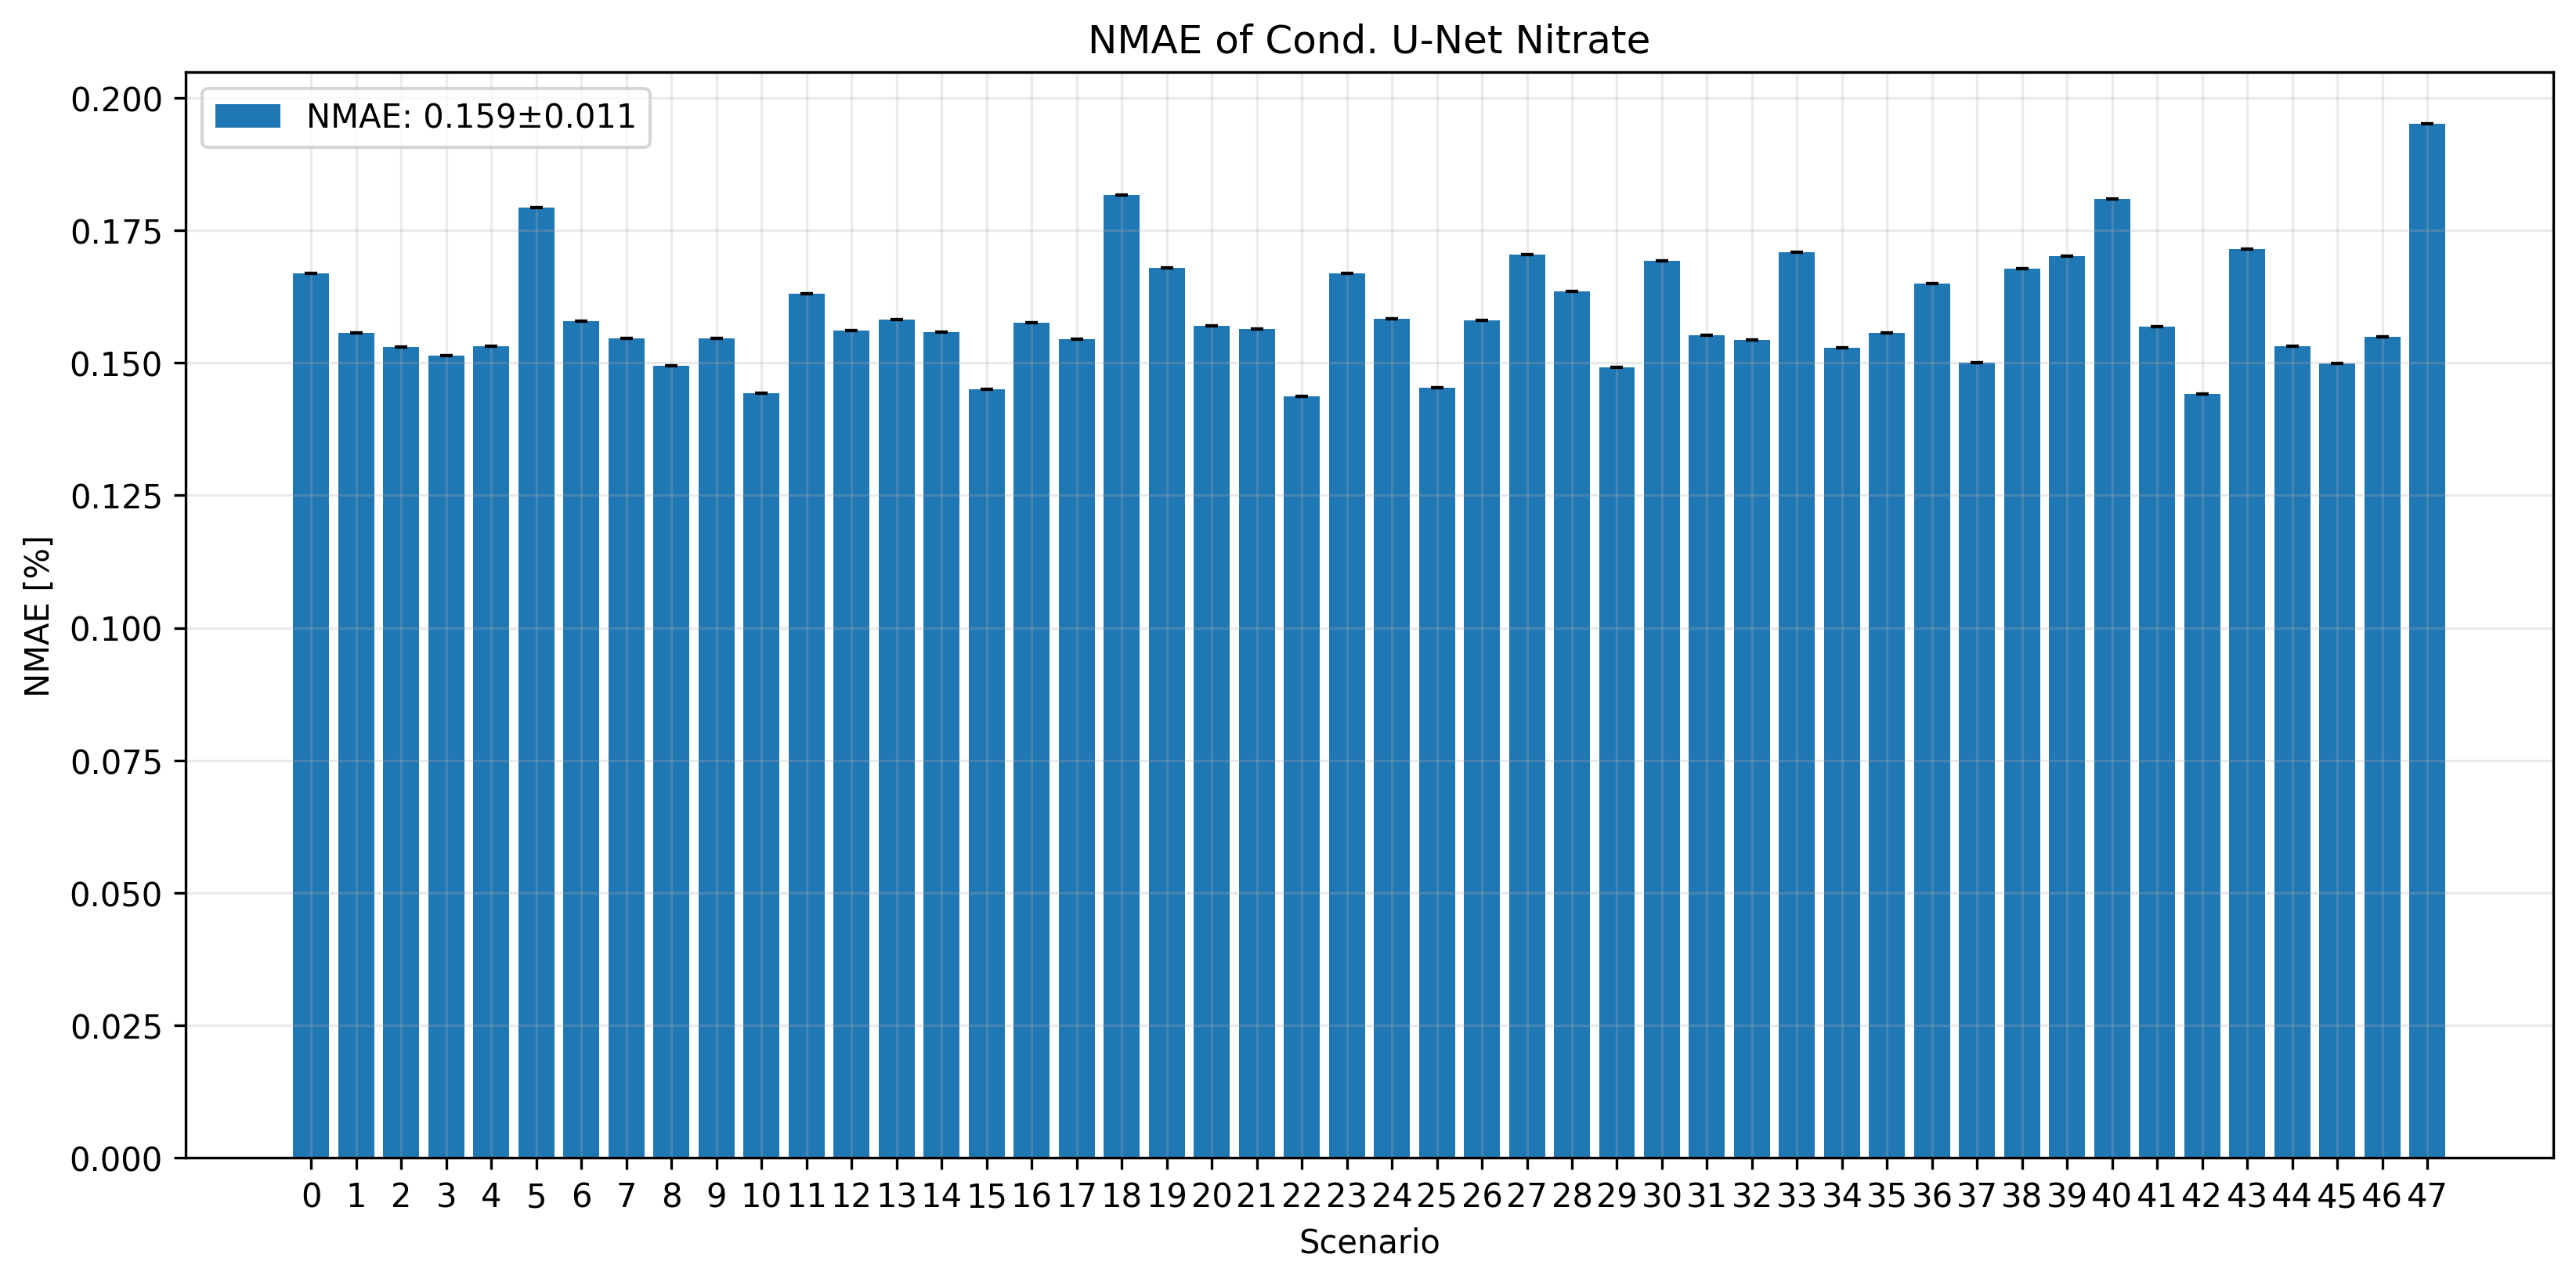

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

In [ ]:
# np.set_printoptions(threshold=sys.maxsize)
# print(true_conc_map_w_lines[17])

[17]


/tmp/ipykernel_1240460/1207372777.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1240460/1207372777.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1240460/1207372777.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1240460/1207372777.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1240460/1207372777.py:67: UserWarning: set_ti

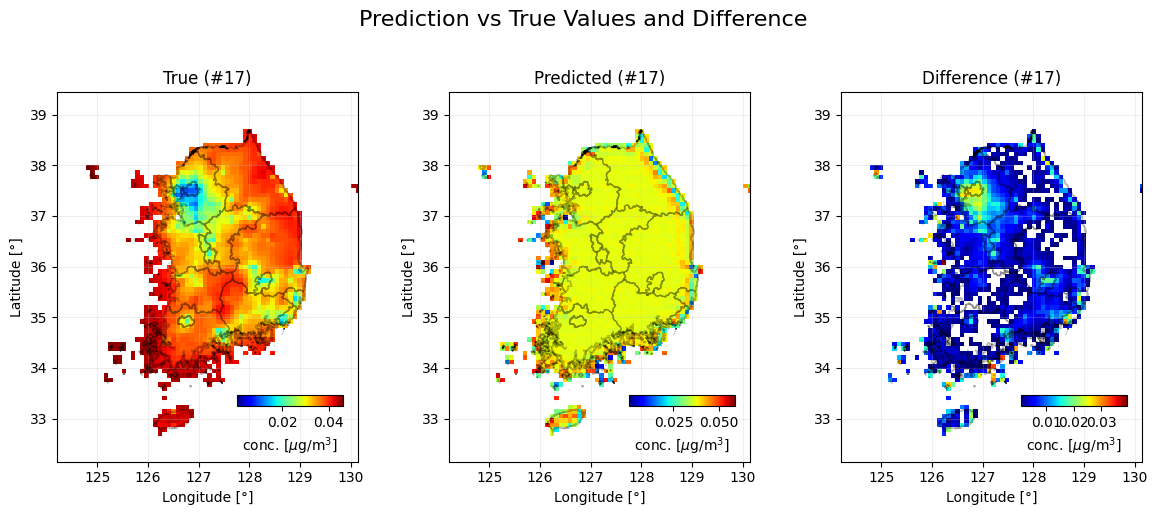

In [ ]:
def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = []
        indices.append(index) 
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=17)

In [ ]:
true_conc_map_w_lines_re = true_conc_map_w_lines
pred_conc_map_w_lines_re = pred_conc_map_w_lines

# 17번 인덱스 제거
true_conc_map_w_lines_re = np.delete(true_conc_map_w_lines, 17, axis=0)
pred_conc_map_w_lines_re = np.delete(pred_conc_map_w_lines, 17, axis=0)

print(true_conc_map_w_lines_re.shape)
print(pred_conc_map_w_lines_re.shape)

(47, 82, 67)
(47, 82, 67)


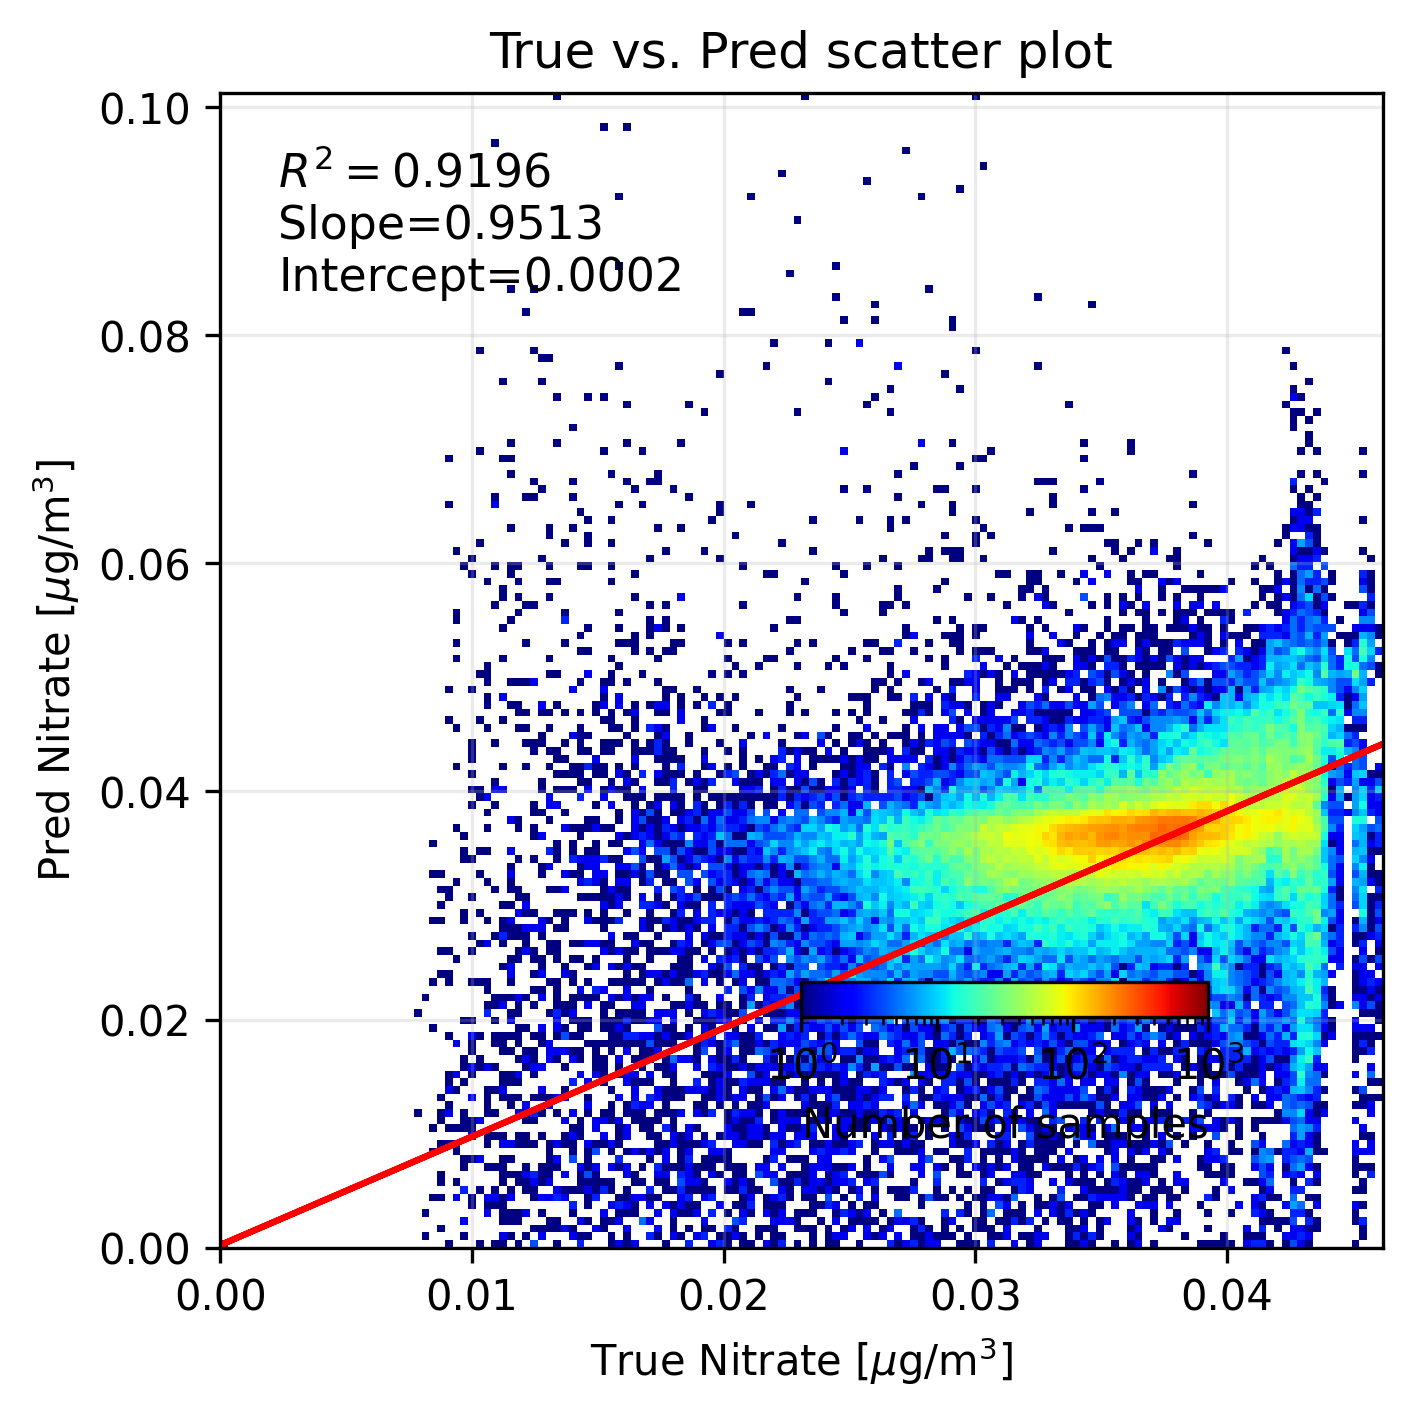

In [ ]:
y_true_modi = true_conc_map_w_lines_re.reshape(-1)
y_pred_modi = pred_conc_map_w_lines_re.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

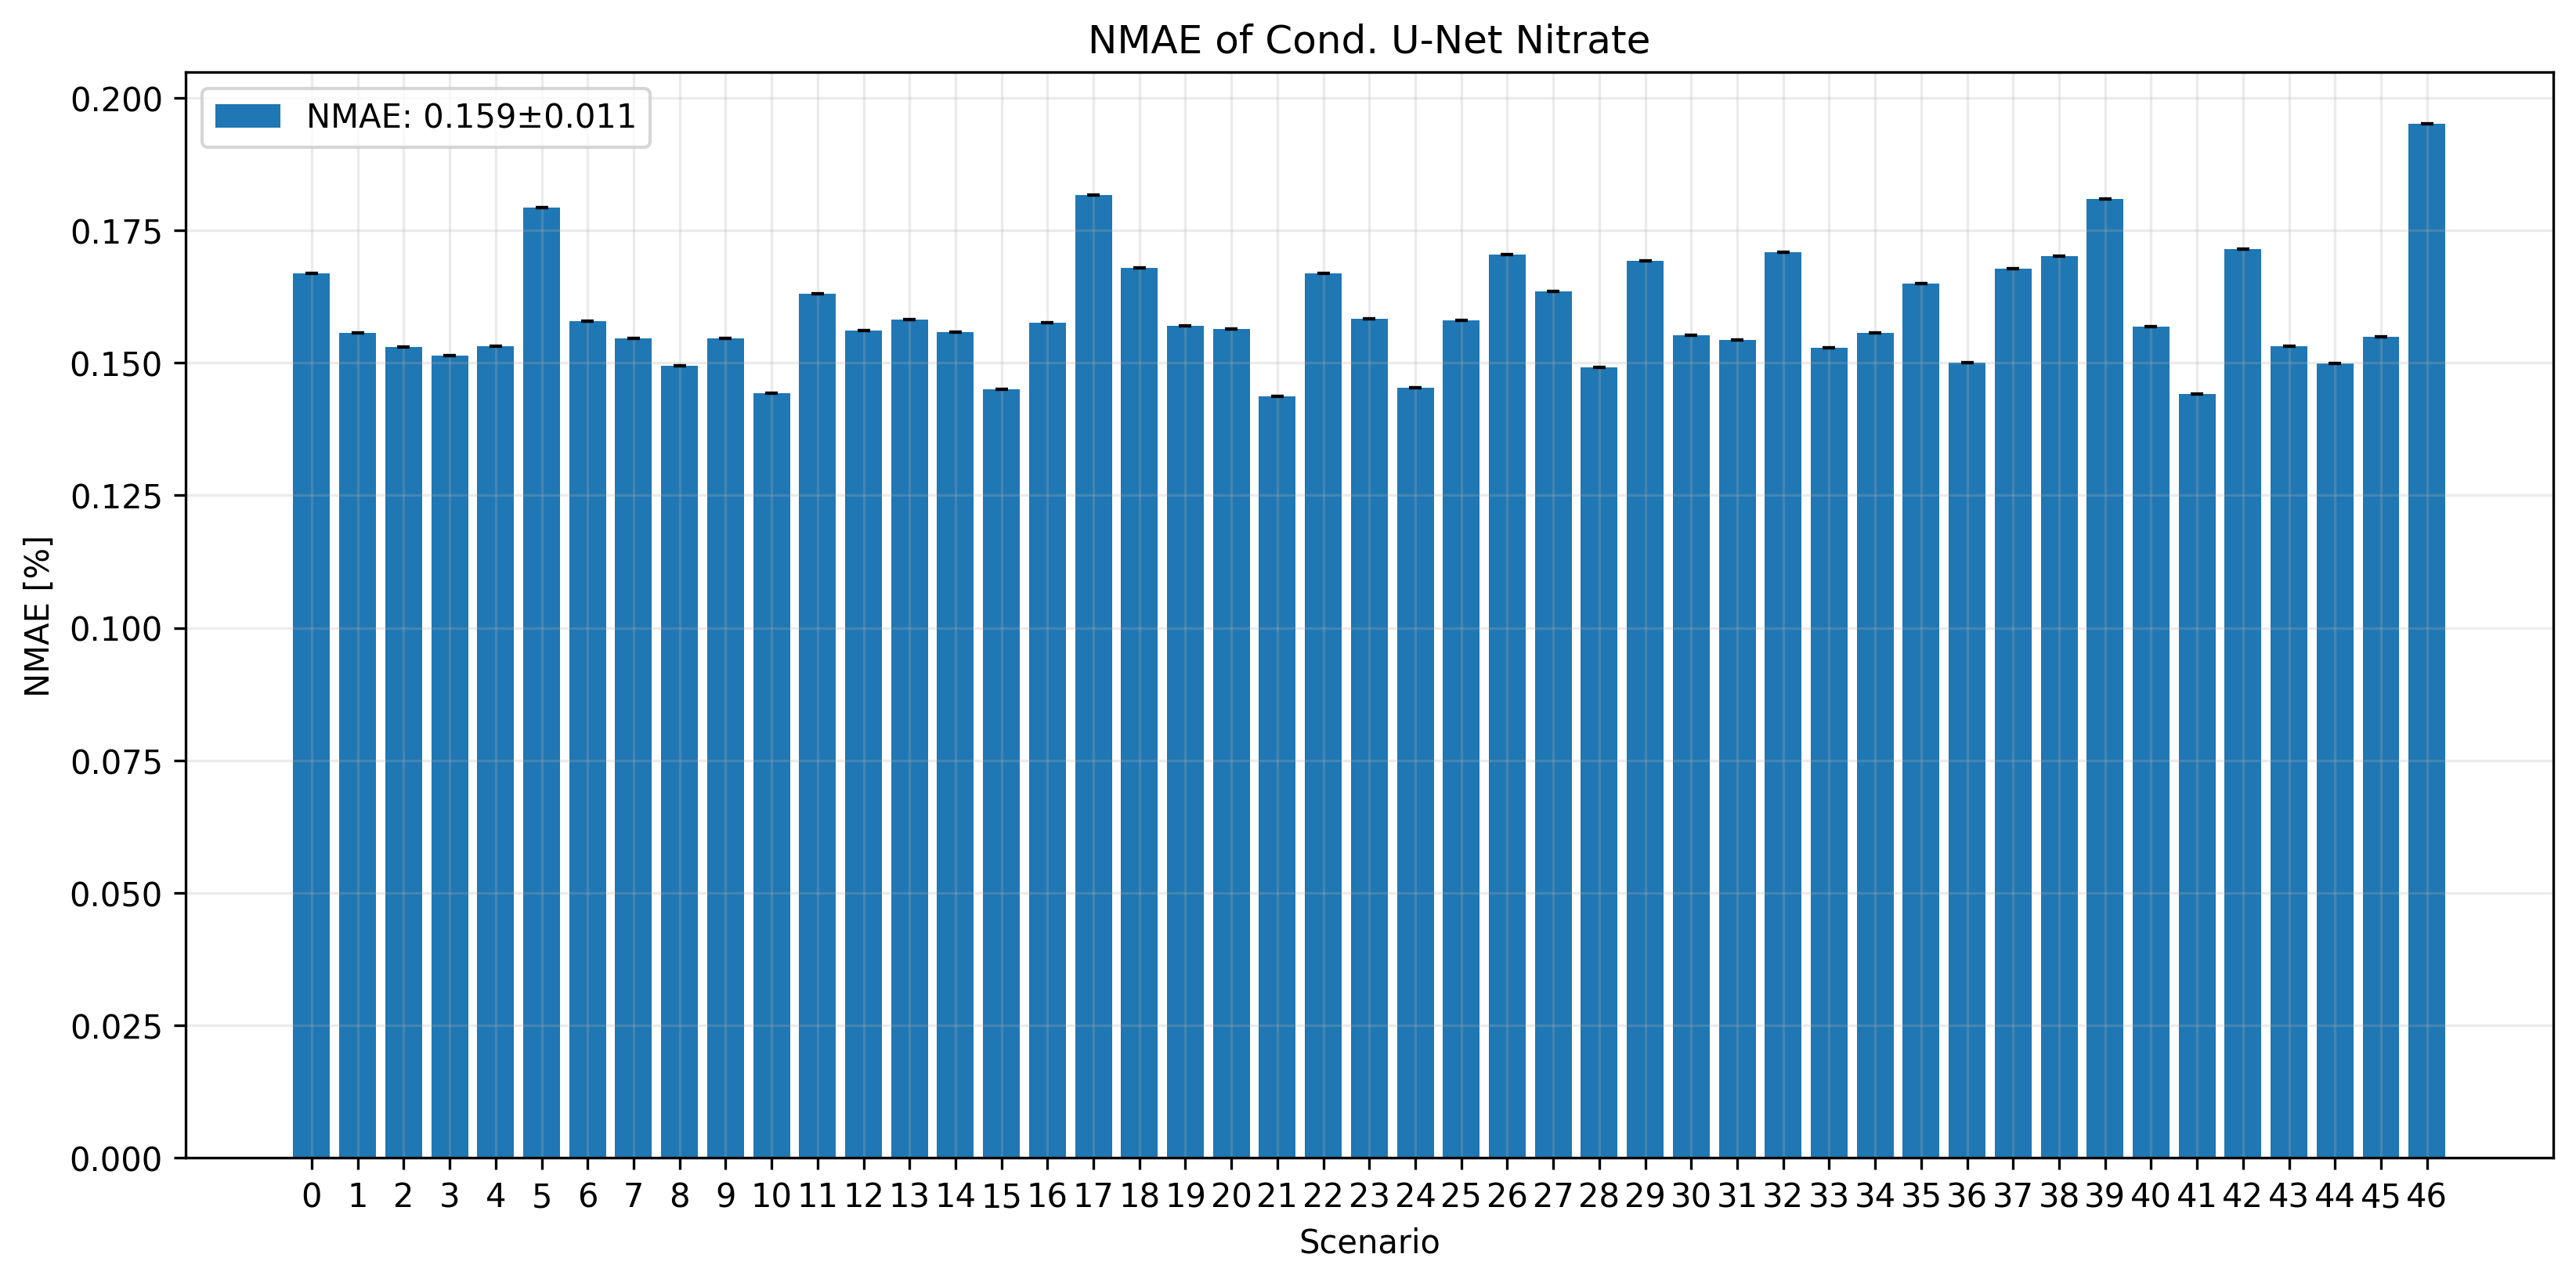

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines_re, pred_conc_map_w_lines_re)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]-1), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]-1), range(y_test.shape[0]-1))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()